In [1]:
from IPython.display import display, HTML
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, pandas_udf, col, PandasUDFType, lit, round, array_contains
from pyspark.sql.types import DoubleType, StructType, StructField
from pyspark.sql.functions import when, split, col
from pyspark.sql import functions as F
from pyspark.sql import Window

import os, time
import subprocess
import os,shutil
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import h3pandas
import h3

# Settings
project = "project_aiu"

# Getting today's date
today = datetime.today().strftime('%d %B %Y')

shutil.copy("/runtime-addons/cmladdon-2.0.40-b154/log4j.properties", "/etc/spark/conf/") # Setting logging properties

# Spark Session Initialization
spark = SparkSession.builder \
    .appName("OSN ADEP ADES Identification") \
    .config("spark.log.level", "ERROR")\
    .config("spark.hadoop.fs.azure.ext.cab.required.group", "eur-app-aiu") \
    .config("spark.kerberos.access.hadoopFileSystems", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged") \
    .config("spark.driver.cores", "1") \
    .config("spark.driver.memory", "8G") \
    .config("spark.executor.memory", "6G") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "20") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "400s") \
    .config("spark.driver.maxResultSize", "4g") \
    .enableHiveSupport() \
    .getOrCreate()

Setting spark.hadoop.yarn.resourcemanager.principal to quinten.goens


In [2]:
# Get environment variables
engine_id = os.getenv('CDSW_ENGINE_ID')
domain = os.getenv('CDSW_DOMAIN')

# Format the URL
url = f"https://spark-{engine_id}.{domain}"

# Display the clickable URL
display(HTML(f'<a href="{url}">{url}</a>'))

## Transfer & filter OPDI runway hexagons

query = """
INSERT INTO project_aiu.opdi_runway_hexagons_bucketed_europe 
SELECT
    AIRPORT_IDENT,
    LE_IDENT,
    LE_HEADING_DEG,
    HE_IDENT,
    HE_HEADING_DEG,
    HEX_ID,
    HEX_RES,
    HEX_LON,
    HEX_LAT,
    GATE_ID,
    GATE_ID_NR
FROM
    project_aiu.opdi_runway_hexagons
WHERE
    HEX_LAT BETWEEN 26.74617 AND 70.25976
    AND HEX_LON BETWEEN -25.86653 AND 49.65699;"""

filtered_df = spark.sql(query)

## Create osn h3 osn statevector sample 7 days

query = """
INSERT INTO project_aiu.osn_h3_statevectors_bucket_sample 
SELECT
    *
FROM
    project_aiu.osn_h3_statevectors
WHERE
    EVENT_TIME BETWEEN 1672531201 AND 1673135999""" 
# First 7 days of 2023, bucketed on icao24, callsign, event_time and h3_res_11

filtered_df = spark.sql(query)

## Testing sample

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import time

def get_data_within_timeframe(spark, table_name, start_date, stop_date):
    """
    Retrieves records from a specified Spark table within the given timeframe.

    Args:
    spark (SparkSession): The SparkSession object.
    table_name (str): The name of the Spark table to query.
    start_date (str): The start date in 'YYYY-MM-DD' format.
    stop_date (str): The stop date in 'YYYY-MM-DD' format.

    Returns:
    pyspark.sql.dataframe.DataFrame: A DataFrame containing the records within the specified timeframe.
    """
    # Convert dates to POSIX time (seconds since epoch)
    start_posix = int(time.mktime(time.strptime(start_date, '%Y-%m-%d')))
    stop_posix = int(time.mktime(time.strptime(stop_date, '%Y-%m-%d')))

    # Load the table
    df = spark.table(table_name)

    # Filter records based on event_time column
    filtered_df = df.filter((col('event_time') > start_posix) & (col('event_time') <= stop_posix))

    return filtered_df

#sdf.write.format('parquet').save("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

sdf = spark.read.format('parquet').load("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

In [4]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import monotonically_increasing_id, row_number, col
from pyspark.sql.window import Window


def add_sv_id(df: DataFrame) -> DataFrame:
    """
    Create a numeric ID for each statevector (sv) in a Spark DataFrame. The IDs start from 1 and are consecutive.
    
    Parameters:
    df (DataFrame): The Spark DataFrame to which the statevector IDs will be added.
    
    Returns:
    DataFrame: A Spark DataFrame with an additional column 'sv_id' that contains the unique, consecutive IDs starting from 1.
    """
    # Define a window specification without partitioning (over all rows)
    window_spec = Window.orderBy(monotonically_increasing_id())
    
    # Add a new column 'statevector_id' which is the row number over the specified window
    df = df.withColumn('sv_id_tmp', row_number().over(window_spec))
    
    # Offset 'statevector_id' to start from 1
    df = df.withColumn('sv_id', df['sv_id_tmp'])
    
    # Drop the temporary column
    df = df.drop('sv_id_tmp')
    
    return df


### Airport helper merge

In [5]:
df_apt = pd.read_parquet('../data/airport_hex/airport_concentric_c_hex_res_6.arrow')

# Filter out relevant hexagons
df_apt = df_apt[df_apt.max_c_radius_nm<=15]
df_apt = df_apt[['ident','hex_id']].explode('hex_id')
df_apt = df_apt[~df_apt.hex_id.isna()]

# Getting h3 positions of hexagons 
df_apt['geo'] = df_apt['hex_id'].apply(lambda l:h3.h3_to_geo(l))
df_apt['lat'] = df_apt['geo'].apply(lambda l:l[0])
df_apt['lon'] = df_apt['geo'].apply(lambda l:l[1])
df_apt = df_apt.drop('geo',axis=1)

# OSN bounding box filter
f_lat = np.logical_and(df_apt.lat >=26.74617, df_apt.lat <= 70.25976)  
f_lon = np.logical_and(df_apt.lon >=-25.86653, df_apt.lon <= 49.65699)  
f = np.logical_and(f_lat, f_lon)
df_apt = df_apt[f]

# Renaming columns 
df_apt.columns = ['apt_' + x for x in df_apt.columns]

# Grouping by hex id
df_apt = df_apt.groupby('apt_hex_id').agg(list)['apt_ident'].reset_index()

# Creating spark df
sdf_apt = spark.createDataFrame(df_apt)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


## Code

### Prep

In [6]:
# Fetch data 
sv = get_data_within_timeframe( # State Vectors sv
    spark = spark, 
    table_name = 'project_aiu.osn_h3_statevectors_bucket_sample', 
    start_date = '2023-01-01', 
    stop_date = '2023-01-08')

# Filter out rows with missing crucial data
sv_f = sv.dropna(subset=['lat', 'lon', 'baro_altitude'])

# Add statevector id
#sv_f = add_sv_id(sv_f)

# Rename callsign to flight_id (official term)
sv_f = sv_f.withColumnRenamed("callsign", "flight_id")

# Add temporary track id (aids later on)
sv_f = sv_f.withColumn('track_id', F.concat_ws('_', F.col('icao24'), F.col('flight_id')))

# Convert event_time 
sv_f = sv_f.withColumn('event_time', F.to_timestamp(F.col('event_time')))

# Add flight level extracted from baro_altitude
sv_f = sv_f.withColumn('flight_level', (col('baro_altitude') * 3.28084 / 100).cast('int'))

# Select columns of interest
columns_of_interest = [
    'track_id', 'icao24', 'flight_id', 'event_time', 'lat', 'lon',  'flight_level',
    'heading', 'vert_rate',  'on_ground', 'h3_res_6', 'h3_res_11'
]

sv_f = sv_f.select(columns_of_interest)

# Label low alt 
sv_low_alt = sv_f.filter(col('flight_level') <= 50).cache()

# Sampling for testing
sv_low_alt = sv_low_alt.limit(100000)

Hive Session ID = 185ef760-3425-4322-ba24-5ae58b035d58


In [7]:
# Merge airports hexaero grid (sdf_apt) onto statevectors to see which tracks are within 15 NM (+-h3 res 6 inaccuracy). 
sv_nearby_apt = sv_low_alt.join(sdf_apt, (sv_low_alt.h3_res_6 == sdf_apt.apt_hex_id), "left")

In [8]:
# Merge nearby runways on the hexaero grid 

## Load runway spark dataframe (rwy_sdf) 
rwy_sdf = spark.table('project_aiu.opdi_runway_hexagons_bucketed_europe')
rwy_cols_of_interest = [
    'airport_ident', 
    'le_ident', 
    'le_heading_deg', 
    'he_ident', 
    'he_heading_deg',
    'hex_id', 
    'gate_id', 
    'gate_id_nr'] 
rwy_sdf = rwy_sdf.select(rwy_cols_of_interest)

sv_on_rwy = sv_nearby_apt.join(
    rwy_sdf, 
    (sv_nearby_apt.h3_res_11 == rwy_sdf.hex_id) & 
    array_contains(sv_nearby_apt.apt_ident, rwy_sdf.airport_ident), 
    "inner")

In [9]:
# Define a window spec partitioned by 'id' and ordered by 'time'
windowSpec = Window.partitionBy("track_id").orderBy("event_time")

# Calculate the time difference between consecutive rows
sv_on_rwy = sv_on_rwy.withColumn("time_diff", F.col("event_time").cast("long") - F.lag("event_time", 1).over(windowSpec).cast("long"))

# Flag rows where the time difference exceeds 40 minutes (40*60 seconds)
sv_on_rwy = sv_on_rwy.withColumn("new_flight_flag", F.when(F.col("time_diff") > 60*40, 1).otherwise(0))

# Cumulative sum of flags to create a sub-id
sv_on_rwy = sv_on_rwy.withColumn("sub_id", F.sum("new_flight_flag").over(windowSpec.rowsBetween(Window.unboundedPreceding, 0)))

# Concatenate original 'id' with 'sub_id' to form a new unique 'id'
sv_on_rwy = sv_on_rwy.withColumn("track_id", F.concat_ws("_", "track_id", "sub_id"))

In [10]:
# Drop redundant columns
sv_on_rwy = sv_on_rwy.drop(*['time_diff', 'new_flight_flag', 'sub_id'])

In [12]:
from pyspark.sql.functions import when, split, col, concat_ws
sv_on_rwy = sv_on_rwy.withColumn(
    "gate_type", 
    when(
        col("gate_id") == "runway_hexagons", "runway_hexagons"
    ).otherwise(
        concat_ws(
            "_", 
            split(col("gate_id"), "_").getItem(0),
            split(col("gate_id"), "_").getItem(1),
            split(col("gate_id"), "_").getItem(2),
            split(col("gate_id"), "_").getItem(3)
        )
    )
).withColumn(
    "gate_distance_from_rwy_nm",
    when(
        col("gate_id") == "runway_hexagons", 0
    ).otherwise(
        split(col("gate_id"), "_").getItem(4).cast("int")
    )
)

In [ ]:
test = sv_on_rwy.toPandas()

In [ ]:
test.gate_type.value_counts()

In [ ]:
5/60

0.08333333333333333

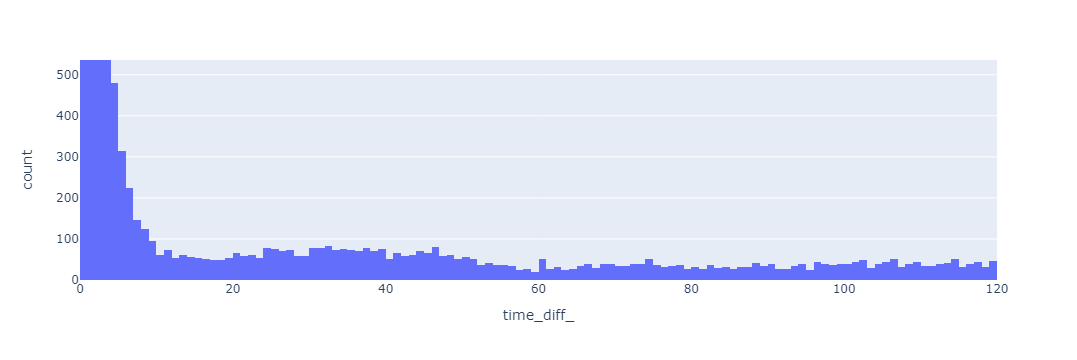

In [ ]:
import plotly.express as px
tmp['time_diff_'] = tmp['time_diff']/60

tmp_ = tmp[tmp['time_diff_'] > 5/60]
tmp_ = tmp_[tmp_['time_diff_'] < 120]
px.histogram(tmp_, x='time_diff_')

In [97]:
tmp.sort_values(['track_id','event_time'])

,track_id,icao24,flight_id,event_time,lat,lon,flight_level,heading,vert_rate,on_ground,...,apt_hex_id,apt_ident,airport_ident,le_ident,le_heading_deg,he_ident,he_heading_deg,hex_id,gate_id,gate_id_nr
11001,0100dd,0100dd,None,2023-01-07 11:20:15,36.787021,3.385834,19,263.589160,-3.90144,False,...,86395a797ffffff,[DAAG],DAAG,05,53.0,23,233.0,8b395a795309fff,low_numbered_approach_hexagons_9_nm,19000
18359,0100dd,0100dd,None,2023-01-07 11:20:20,36.786602,3.384140,19,263.589160,-3.90144,False,...,86395a797ffffff,[DAAG],DAAG,05,53.0,23,233.0,8b395a795303fff,low_numbered_approach_hexagons_9_nm,19000
18360,0100dd,0100dd,None,2023-01-07 11:20:25,36.786602,3.384140,19,263.589160,-3.90144,False,...,86395a797ffffff,[DAAG],DAAG,05,53.0,23,233.0,8b395a795303fff,low_numbered_approach_hexagons_9_nm,19000
18361,0100dd,0100dd,None,2023-01-07 11:20:30,36.786602,3.384140,19,263.589160,-3.90144,False,...,86395a797ffffff,[DAAG],DAAG,05,53.0,23,233.0,8b395a795303fff,low_numbered_approach_hexagons_9_nm,19000
18362,0100dd,0100dd,None,2023-01-07 11:20:35,36.786602,3.384140,19,263.589160,-3.90144,False,...,86395a797ffffff,[DAAG],DAAG,05,53.0,23,233.0,8b395a795303fff,low_numbered_approach_hexagons_9_nm,19000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37553,e48ced_PPCFJ,e48ced,PPCFJ,2023-01-07 11:02:05,41.793137,12.598884,5,156.236178,18.53184,False,...,861e8042fffffff,"[LIRA, LIRE, LIRG, LIRU]",LIRA,15,152.0,33,332.0,8b1e8042e331fff,runway_hexagons,20000
22877,e48ced_PPCFJ,e48ced,PPCFJ,2023-01-07 11:02:10,41.788035,12.601957,10,155.170653,18.85696,False,...,861e8042fffffff,"[LIRA, LIRE, LIRG, LIRU]",LIRA,15,152.0,33,332.0,8b1e8042e2a9fff,low_numbered_approach_hexagons_1_nm,11000
26619,e48ced_PPCFJ,e48ced,PPCFJ,2023-01-07 11:02:15,41.786034,12.603171,12,154.425555,13.65504,False,...,861e8042fffffff,"[LIRA, LIRE, LIRG, LIRU]",LIRA,15,152.0,33,332.0,8b1e8042e2d2fff,low_numbered_approach_hexagons_1_nm,11000
4623,e48ced_PPCFJ,e48ced,PPCFJ,2023-01-07 11:02:20,41.783985,12.604512,14,160.676816,13.32992,False,...,861e8042fffffff,"[LIRA, LIRE, LIRG, LIRU]",LIRA,15,152.0,33,332.0,8b1e8042a90bfff,low_numbered_approach_hexagons_2_nm,12000


In [55]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming arr_dep_apt is your Spark DataFrame and 'track_id_col' is defined

# Step 1: Initialize the 'segment_status' column with an empty string
arr_dep_apt = arr_dep_apt.withColumn('segment_status', F.lit(''))

# Step 2: Create a window specification partitioned by 'track_id_col' and 'ident'
track_id_col = 'track_id_tmp'
windowSpec = Window.partitionBy(track_id_col, 'apt_ident')

# Finding the min and max time for each group
min_time = F.min('event_time').over(windowSpec)
max_time = F.max('event_time').over(windowSpec)

# Step 3: Mark the 'start' and 'end' based on the min and max times
arr_dep_apt = arr_dep_apt.withColumn('segment_status', 
                                     F.when(F.col('event_time') == min_time, 'start')
                                     .when(F.col('event_time') == max_time, 'end')
                                     .otherwise(F.col('segment_status')))

# Step 4: Filter to only include 'start' or 'end'
filtered_df = arr_dep_apt.filter(F.col('segment_status').isin(['start', 'end']))


In [56]:
tmp = filtered_df.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [58]:
tmp.columns

Index(['event_time', 'icao24', 'lat', 'lon', 'velocity', 'heading',
       'vert_rate', 'callsign', 'on_ground', 'alert', 'spi', 'squawk',
       'baro_altitude', 'geo_altitude', 'last_pos_update', 'last_contact',
       'serials', 'h3_res_12', 'h3_res_11', 'h3_res_10', 'h3_res_9',
       'h3_res_8', 'h3_res_7', 'h3_res_6', 'h3_res_5', 'h3_res_4', 'h3_res_3',
       'h3_res_2', 'h3_res_1', 'h3_res_0', 'baroaltitude_ft',
       'baroaltitude_fl', 'low_alt', 'apt_hex_id', 'apt_ident', 'track_id_tmp',
       'segment_status'],
      dtype='object')

### Main runway merge

In [11]:
from pyspark.sql.functions import collect_list

In [12]:
rwy_sdf_dedup = rwy_sdf.groupBy("hex_id", "hex_res", "hex_lon", "hex_lat").agg(
    collect_list("airport_ident").alias("airport_ident_list"),
    collect_list("le_ident").alias("le_ident_list"),
    collect_list("le_heading_deg").alias("le_heading_deg_list"),
    collect_list("he_ident").alias("he_ident_list"),
    collect_list("he_heading_deg").alias("he_heading_deg_list"),
    collect_list("gate_id").alias("gate_id_list"),
    collect_list("gate_id_nr").alias("gate_id_nr_list")
)

In [24]:
df = sdf_fi.toPandas()

In [30]:
tmp = df[~df['gate_id_list'].isna()]

In [35]:
tmp.id.value_counts()

440614_EJU74QN     101
4cad3f_RYR56JP      96
40624f_SHT9Y        84
40600d_EZY36BN      65
45ac37_SAS688       49
48414c_TRA16E       47
392af8_AFR14DF      45
4b1a29_EZS18TE      37
393323_AFR36TM      31
4010ee_EZY87RE      29
4d012c_CLX9874      29
71005b_SVA9062      17
Name: id, dtype: int64

In [38]:
tmp[tmp.id.str.contains('440614_EJU74QN')].sort_values('event_time')

,event_time,icao24,lat,lon,velocity,heading,vert_rate,callsign,on_ground,alert,...,hex_lon,hex_lat,airport_ident_list,le_ident_list,le_heading_deg_list,he_ident_list,he_heading_deg_list,gate_id_list,gate_id_nr_list,id
1513,1672951360,440614,44.942089,-0.552934,95.309689,225.437364,-2.60096,EJU74QN,False,False,...,-0.552861,44.941940,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_10_nm],[10000],440614_EJU74QN
2354,1672951365,440614,44.938225,-0.558494,94.582177,225.440728,-5.20192,EJU74QN,False,False,...,-0.558716,44.938240,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_10_nm],[10000],440614_EJU74QN
3749,1672951370,440614,44.934967,-0.563183,93.863124,225.888235,-5.20192,EJU74QN,False,False,...,-0.563169,44.935062,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_10_nm],[10000],440614_EJU74QN
4456,1672951375,440614,44.931754,-0.567806,92.766964,225.674037,-5.20192,EJU74QN,False,False,...,-0.567622,44.931885,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_9_nm],[19000],440614_EJU74QN
4457,1672951380,440614,44.928772,-0.572074,91.311999,225.684778,-5.52704,EJU74QN,False,False,...,-0.572074,44.928707,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_9_nm],[19000],440614_EJU74QN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1672951840,440614,44.842560,-0.695421,68.025372,225.306392,-3.90144,EJU74QN,False,False,...,-0.695178,44.842491,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_2_nm],[12000],440614_EJU74QN
1147,1672951845,440614,44.842560,-0.695421,68.025372,225.306392,-3.90144,EJU74QN,False,False,...,-0.695178,44.842491,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_2_nm],[12000],440614_EJU74QN
1148,1672951850,440614,44.842560,-0.695421,68.025372,225.306392,-3.90144,EJU74QN,False,False,...,-0.695178,44.842491,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_2_nm],[12000],440614_EJU74QN
1149,1672951855,440614,44.842560,-0.695421,68.025372,225.306392,-3.90144,EJU74QN,False,False,...,-0.695178,44.842491,[LFBD],[05],[46.0],[23],[226.0],[low_numbered_approach_hexagons_2_nm],[12000],440614_EJU74QN


In [28]:
df['id'].value_counts()

KeyError: 'id'

In [15]:
df[df.baro_altitude.isna()]

,event_time,icao24,lat,lon,velocity,heading,vert_rate,callsign,on_ground,alert,...,hex_res,hex_lon,hex_lat,airport_ident_list,le_ident_list,le_heading_deg_list,he_ident_list,he_heading_deg_list,gate_id_list,gate_id_nr_list
